In [1]:
# 이미지 분할
# 필요한 이미지 다운로드

In [6]:
import urllib.request as req
import zipfile
def downloadImageFromUrl(url,filename,targetDir):
    with req.urlopen(url) as f:
        with open(targetDir+'/'+filename,'wb') as of:
            of.write(f.read())
    zipfile.ZipFile(targetDir+'/'+filename).extractall()           
    
# url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
# import urllib.request as req
# with req.urlopen(url) as f:
#     with open('jena_climate_2009_2016.csv.zip','wb') as of:
#         of.write(f.read())
# import zipfile
# zipfile.ZipFile('./jena_climate_2009_2016.csv.zip').extractall()        

In [3]:
url1 = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
url2= 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'

In [4]:
import os
os.mkdir('./image_segmentation')

In [14]:
# downloadImageFromUrl(url1,'images.tar.gz','./image_segmentation')
# zipfile.ZipFile('./image_segmentation/images.tar.gz').extractall()     
# !tar -xvzf './image_segmentation/images.tar.gz'

In [16]:
# downloadImageFromUrl(url2,'annotations.tar.gz','./image_segmentation')

In [26]:
input_dir = 'images/'
target_dir = 'annotations/trimaps/'

In [18]:
pwd

'D:\\leeky_ai'

In [19]:
os.chdir('D:\leeky_ai\image_segmentation')

In [20]:
pwd

'D:\\leeky_ai\\image_segmentation'

In [21]:
input_img_paths = sorted(
    [os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')]    
)

In [24]:
import glob

In [33]:
target_paths =  glob.glob(target_dir+'/*.png')

In [35]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

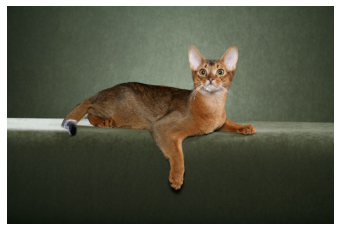

In [40]:
plt.imshow(load_img(input_img_paths[0]))
plt.axis('off')
plt.show()